In [2]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg16 import VGG16
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
model = VGG16(input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [203]:
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = Flatten()(model.output)
# gap = GlobalAveragePooling2D(x)
predictions = Dense(7, activation='softmax')(x) # output_shape 
custom_model = Model(model.input, predictions)

In [204]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [52]:
import pandas as pd

data = pd.read_csv('./dataset.csv',index_col=0)

In [53]:
data.head(2)

,identifier,sex,age_group,age,height,weight,report,pneumonia_type,orginal_dcm_file,body_part_file,diagnosis
0,H05_00019_02,M,A1,0개월,NaN,0.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4
1,H01_00716_01,F,A1,0개월,52.0,3.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4


In [60]:
def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data['diagnosis'] = data['diagnosis'].apply(normal_dia)

In [64]:
len(data)

4000

In [65]:
dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

In [66]:
len(img_path_list)

4000

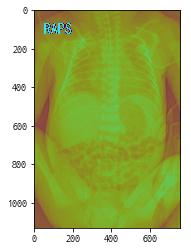

In [21]:
import cv2
import matplotlib.pyplot as plt

plt.imshow(cv2.imread(img_path_list[0]))

In [67]:
import numpy as np

def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)

In [73]:
import tqdm

X = np.ndarray((4000,224,224,3))

for i in range(len(X)):
    X[i][:][:][:] = rv_3ch(img_path_list[i], mask_path_list[i], (224,224))

In [74]:
Y = data['diagnosis']
Ya = np.array(Y)

In [75]:
Y = data['diagnosis']
Ya = np.array(Y)

In [76]:
print(X.shape)
print(Ya.shape)

(4000, 224, 224, 3)
(4000,)


In [77]:
from sklearn.model_selection import train_test_split

Xtr, Xtst, Ytr, Ytst = train_test_split(X,Ya, test_size=0.2, random_state=42, stratify=Ya)

In [78]:
print(Xtr.shape)

(3200, 224, 224, 3)


In [206]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
from tensorflow.keras.utils import to_categorical

Yc = to_categorical(Ytr)
Ytc = to_categorical(Ytst)

In [211]:
# model.fit(Xtr, Yc, validation_split=0.2, batch_size=16, epochs=5)

history = custom_model.fit(Xtr, Yc, epochs=60, batch_size=16, verbose=1,
          validation_split=0.1)
# model.fit(Xtr, Yc, epochs=5, batch_size=16, verbose=1, validation_data(X_val, y_val)

Train on 2880 samples, validate on 320 samples
Epoch 1/60
2880/2880 [==============================] - 52s 18ms/sample - loss: 1.8057 - acc: 0.2476 - val_loss: 1.7765 - val_acc: 0.2375
Epoch 2/60
2880/2880 [==============================] - 53s 18ms/sample - loss: 1.8021 - acc: 0.2417 - val_loss: 1.7724 - val_acc: 0.2375
Epoch 3/60
2880/2880 [==============================] - 53s 18ms/sample - loss: 1.8001 - acc: 0.2479 - val_loss: 1.7704 - val_acc: 0.2375
Epoch 4/60
2880/2880 [==============================] - 53s 18ms/sample - loss: 1.7990 - acc: 0.2514 - val_loss: 1.7690 - val_acc: 0.2375
Epoch 5/60
2880/2880 [==============================] - 53s 18ms/sample - loss: 1.7981 - acc: 0.2448 - val_loss: 1.7680 - val_acc: 0.2375
Epoch 6/60
2880/2880 [==============================] - 53s 18ms/sample - loss: 1.7979 - acc: 0.2351 - val_loss: 1.7670 - val_acc: 0.2375
Epoch 7/60
2880/2880 [==============================] - 53s 18ms/sample - loss: 1.7975 - acc: 0.2514 - val_loss: 1.7667 - val

KeyboardInterrupt: 